In [1]:
import pandas as pd
import numpy as np
import flip_data
import ridge_gd_poisoner
import datetime
import matplotlib.pyplot as plt
from sklearn import linear_model



In [2]:
poi_train_x = pd.read_csv('train_X.csv')
poi_train_x = np.matrix(poi_train_x.to_numpy())
poi_train_y = pd.read_csv('train_y.csv')
poi_train_y = poi_train_y['Life Expectancy'].tolist()
poi_test_x = pd.read_csv('test_X.csv')
poi_test_x = np.matrix(poi_test_x.to_numpy())
poi_test_y = pd.read_csv('test_y.csv')
poi_test_y = poi_test_y['Life Expectancy'].tolist()
poi_val_x = pd.read_csv('val_X.csv')
poi_val_x = np.matrix(poi_val_x.to_numpy())
poi_val_y = pd.read_csv('val_y.csv')
poi_val_y = poi_val_y['Life Expectancy'].tolist()

# num of points to train model
train_ct = len(poi_train_x)
test_ct = len(poi_test_x)
print ("Train count: ", train_ct, " Test count: ", test_ct)

Train count:  1319  Test count:  165


In [3]:
def compute_error(classifier, plot, poisoned):
    # Compute predicted values
    test_y_pred = classifier.predict(poi_test_x)
    valid_y_pred = classifier.predict(poi_val_x)
    if (plot is True):
        plt.scatter(poi_test_y, test_y_pred)
        if (poisoned is True):
            plt.title("Flipped & Poisoned")
        else:
            plt.title("Flipped")
        plt.xlabel("Testing Data")
        plt.ylabel("Testing Predicted")
        plt.show()
        plt.scatter(poi_val_y, valid_y_pred)
        plt.xlabel("Validation Data")
        plt.ylabel("Validation Predicted")
        plt.show()
    # Compute squared errors
    test_mse = np.mean((test_y_pred - poi_test_y) ** 2)
    valid_mse = np.mean((valid_y_pred - poi_val_y) ** 2)
    return valid_mse, test_mse

# Inverse Flip & Ridge Poisoner

classifier:  Ridge(alpha=0.1, max_iter=10000)


*****************************
**** Poison Count:  54  ****
*****************************
Initial Iteration 
Current Loss:  0.043372653070003486
Validation MSE  0.005051706953428866 
Test MSE  0.00715206158856557
 
Iteration  1
Loss: 0.044612031494032  Difference:  0.001239378424028513
 
Iteration  2
Loss: 0.04483237289823391  Difference:  0.0002203414042019139
 
Iteration  3
Loss: 0.0450550536770106  Difference:  0.0002226807787766849
 
Iteration  4
Loss: 0.045712916806851966  Difference:  0.0006578631298413684
 
Iteration  5
Loss: 0.04586163245565149  Difference:  0.0001487156487995217
 
Iteration  6
Loss: 0.04557397180695888  Difference:  -0.00028766064869260866
NO PROGRESS MADE!
 
Iteration  7
Loss: 0.04565608837313608  Difference:  -0.00020554408251540618
NO PROGRESS MADE!
 
Iteration  8
Loss: 0.047163305902902034  Difference:  0.0013016734472505453
 
Iteration  9
Loss: 0.04696115057346819  Difference:  -0.0002021553294338438
NO PROGR

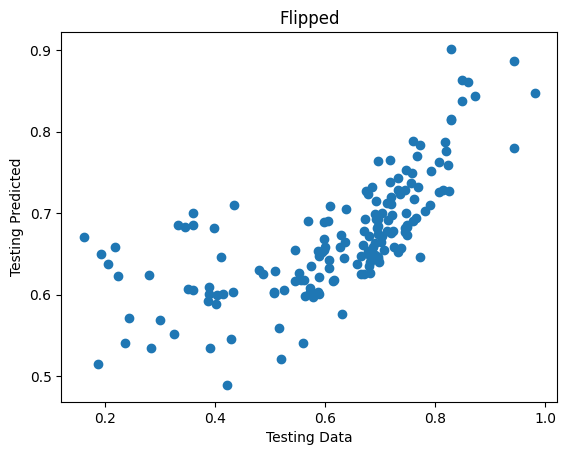

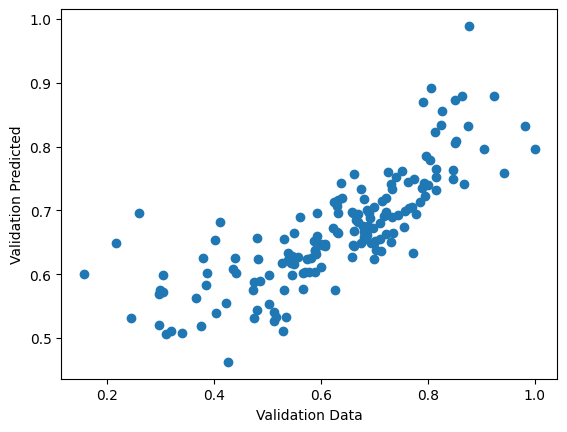

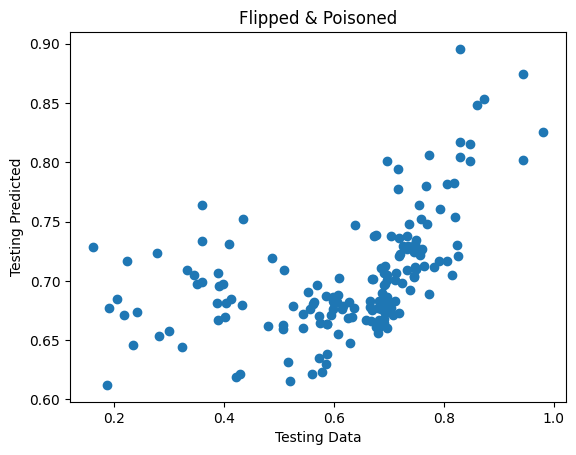

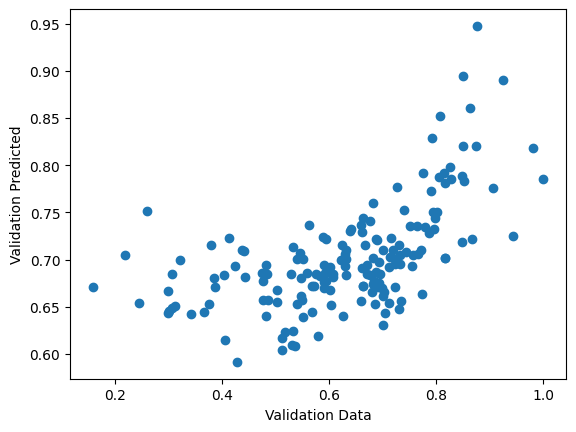


Poison Proportion:  20.0 %. Max reached, terminate

After Flipping, Unpoisoned 
 Validation MSE:  0.013360012686502094 
 Test MSE: 0.019169617515771165

After Flipping & Poisoning:
 Validation MSE:  0.024332030622066327 
 Test MSE: 0.02912878042101597


In [4]:
# define parameters for poisoner
eta = 0.02 # gradient descent step size (note gradients are normalized)
beta = 0.05 # decay rate for line search
sigma = 0.9 # line search stop condition
epsilon = 1e-4 # poisoning stop condition
stop1 = 10 # minimum iterations
stop2 = 30 # maximum iterations
stop3 = 10 # maximum no progress count, if exceeds, give up and stop
decrease_rate = 0.75 # decrease rate of eta if no progress made

poiser = ridge_gd_poisoner.poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
"""
Evaluate the poisoning attack with the poison rate of 4%, 8%, 12%, 16%, 20%
"""
for i in [0.04, 0.08, 0.12, 0.16, 0.20]:
    # calculate the amt of data that should be poisoned in this iteration
    sample_amt = int(train_ct*(i/(1 - i)))
    # flip the data
    x_flip, y_flip = flip_data.flip_data.inverse_flip(poi_train_x,poi_train_y,sample_amt)
    classifier = linear_model.Ridge(alpha=0.1, max_iter=10000)
    classifier.fit(np.vstack((poi_train_x, x_flip)), poi_train_y + y_flip,)
    print("classifier: ", classifier)
    err = compute_error(classifier,False,False)[0]
    # Get the current time before running the code
    start_time = datetime.datetime.now()
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(np.matrix(x_flip), y_flip[:],stop1, stop2, stop3, decrease_rate)
    x_poised = np.vstack((poi_train_x,x_pois_result))
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised = linear_model.Ridge(alpha=0.1, max_iter=10000)
    classifier_poised.fit(x_poised,y_poised)
    # Get the current time after running the code
    end_time = datetime.datetime.now()
    print("Poisoned classifier: ", classifier_poised)
    # Calculate the difference between the start and end times
    time_diff = end_time - start_time
    print("Total running time (seconds):", time_diff.total_seconds())
    classifier = poiser.init_classifier
    if i != 0.20:
        err_unpoised = compute_error(classifier,False,False)
        err = compute_error(classifier_poised,False,False)
        print("\nPoison Proportion: ", i*100,"%")
    else:
        err_unpoised = compute_error(classifier,True,False)
        err = compute_error(classifier_poised,True,True)
        print("\nPoison Proportion: ", i*100, "%. Max reached, terminate")
    print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
    print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])

# B Flip & Ridge Poisoner

classifier:  Ridge(alpha=0.1, max_iter=10000)


*****************************
**** Poison Count:  54  ****
*****************************
Initial Iteration 
Current Loss:  0.04140194648628633
Validation MSE  0.0052308820357393525 
Test MSE  0.005424427032603573
 
Iteration  1
Loss: 0.03949586650052422  Difference:  -0.0019060799857621158
NO PROGRESS MADE!
 
Iteration  2
Loss: 0.03966607151047334  Difference:  -0.0017358749758129913
NO PROGRESS MADE!
 
Iteration  3
Loss: 0.03978016178797142  Difference:  -0.001621784698314914
NO PROGRESS MADE!
 
Iteration  4
Loss: 0.03951767082731744  Difference:  -0.001884275658968891
NO PROGRESS MADE!
 
Iteration  5
Loss: 0.040058190154651285  Difference:  -0.0013437563316350473
NO PROGRESS MADE!
 
Iteration  6
Loss: 0.0401197593087553  Difference:  -0.0012821871775310356
NO PROGRESS MADE!
 
Iteration  7
Loss: 0.04035936616882546  Difference:  -0.0010425803174608714
NO PROGRESS MADE!
 
Iteration  8
Loss: 0.04040031589034539  Difference:  -0.00100163059

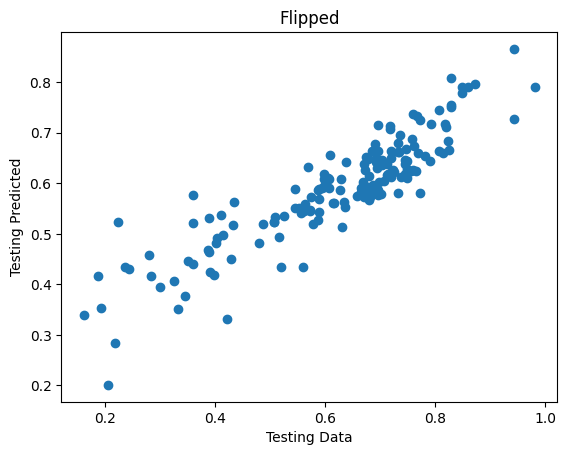

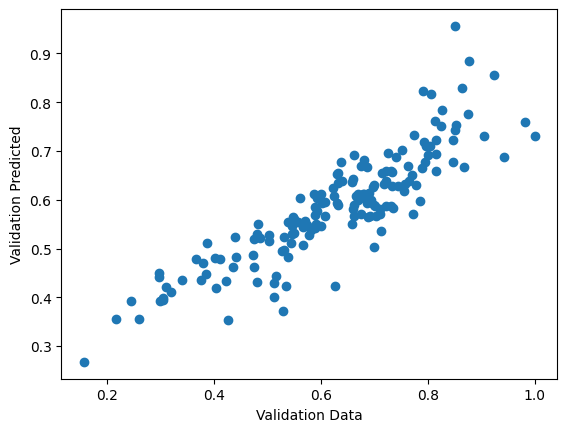

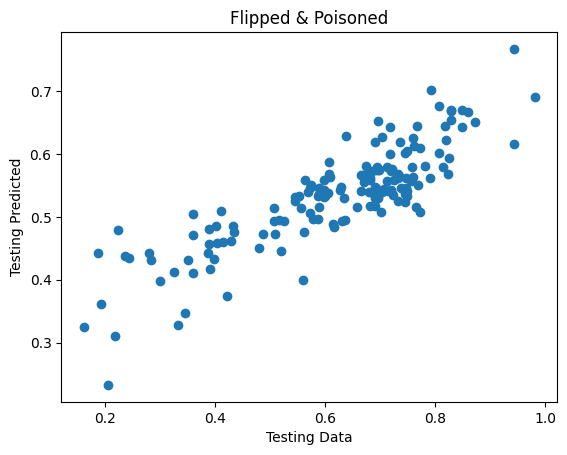

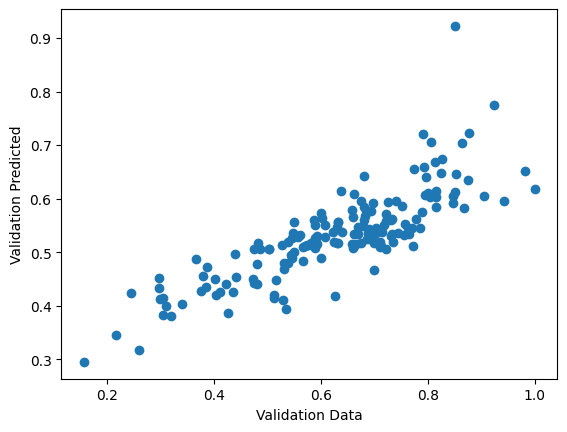


Poison Proportion:  20.0 %. Max reached, terminate

After Flipping, Unpoisoned 
 Validation MSE:  0.00887667026794766 
 Test MSE: 0.009001076691290156

After Flipping & Poisoning:
 Validation MSE:  0.020612580457447315 
 Test MSE: 0.019687273834342617


In [5]:
poiser = ridge_gd_poisoner.poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)

for i in [0.04, 0.08, 0.12, 0.16, 0.20]:
    # calculate the amt of data that should be poisoned in this iteration
    sample_amt = int(train_ct*(i/(1 - i)))
    # flip the data
    x_flip, y_flip = flip_data.flip_data.B_flip(poi_train_x,poi_train_y,sample_amt)
    classifier = linear_model.Ridge(alpha=0.1, max_iter=10000)
    classifier.fit(np.vstack((poi_train_x, x_flip)), poi_train_y + y_flip,)
    print("classifier: ", classifier)
    err = compute_error(classifier,False,False)[0]
    # Get the current time before running the code
    start_time = datetime.datetime.now()
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(np.matrix(x_flip), y_flip[:],stop1, stop2, stop3, decrease_rate)
    x_poised = np.vstack((poi_train_x,x_pois_result))
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised = linear_model.Ridge(alpha=0.1, max_iter=10000)
    classifier_poised.fit(x_poised,y_poised)
    # Get the current time after running the code
    end_time = datetime.datetime.now()
    print("Poisoned classifier: ", classifier_poised)
    # Calculate the difference between the start and end times
    time_diff = end_time - start_time
    print("Total running time (seconds):", time_diff.total_seconds())
    classifier = poiser.init_classifier
    if i != 0.20:
        err_unpoised = compute_error(classifier,False,False)
        err = compute_error(classifier_poised,False,False)
        print("\nPoison Proportion: ", i*100,"%")
    else:
        err_unpoised = compute_error(classifier,True,False)
        err = compute_error(classifier_poised,True,True)
        print("\nPoison Proportion: ", i*100, "%. Max reached, terminate")
    print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
    print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])